In [1]:
import os
import warnings
import time
from copy import deepcopy

import numpy as np 

from scipy.stats import chisquare
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve, Gaussian2DKernel
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties, SourceProperties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, angular_to_pixel, natural_sort, plot_target, get_interpolated_values
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D, model_to_image
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, get_source_position, deblend_segments, segm_mask, masked_segm_image
from lcbg.photometry import flux_to_abmag, order_cat, calculate_photometic_density, plot_apertures, radial_elliptical_aperture, radial_elliptical_annulus, plot_apertures
from lcbg.cosmology import cosmo_aperture_diameter
from lcbg.petrosian import calculate_petrosian, calculate_petrosian_r, calculate_r_half_light, calculate_r_total_flux, plot_petrosian

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Do Aperture Photomerty

In [7]:
current_filter =  filter_list[0]
input_data_path = input_data_formatter.format(current_filter)
output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

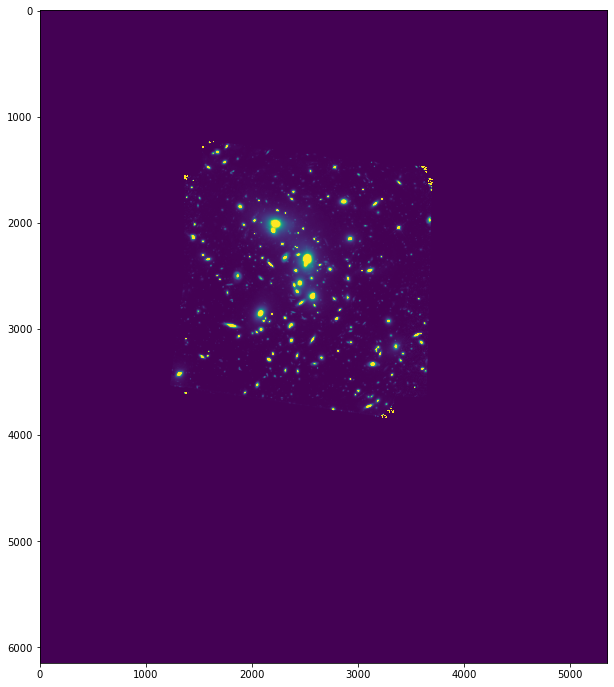

In [8]:
# Load data and vitals
# ---------------------
data = CCDData.read(input_data_path)

plt.imshow(data, vmin=0, vmax=data.data.mean()*10)

0.00013421536 0.0038452926 0.010107331


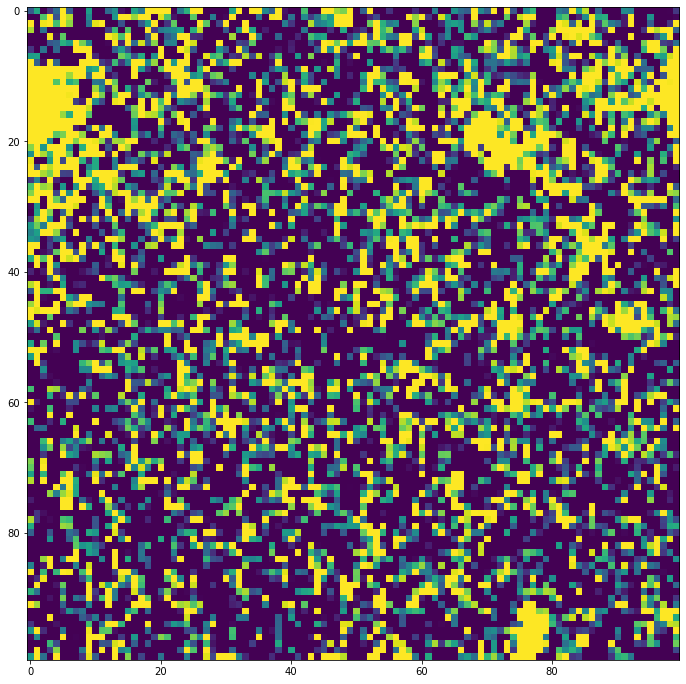

In [9]:
# Estimate data noise at dark area
# --------------------------------
noise_cutout = Cutout2D(data, (2779, 3390), 100)

noise_mean = noise_cutout.data.mean()
noise_3_sigma = np.unique(detect_threshold(noise_cutout.data, nsigma=3))[0] # Single value
noise_8_sigma = np.unique(detect_threshold(noise_cutout.data, nsigma=8))[0] # Single value

plt.imshow(noise_cutout.data, vmax=noise_cutout.data.mean()*10, vmin=0)
print(noise_mean, noise_3_sigma, noise_8_sigma)

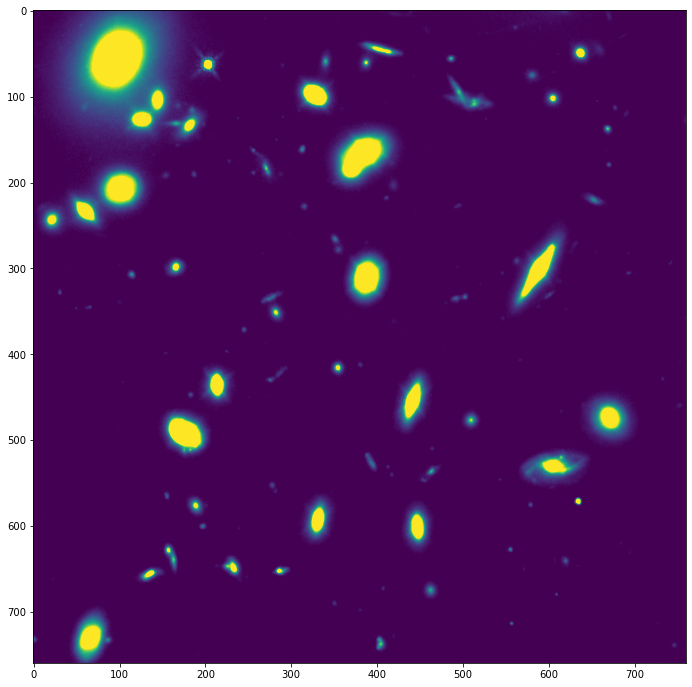

In [10]:
# Cutout Image
# -------------
# Select and crop image:
# Center of cluster:
#cx, cy = [int(np.round(i)) for i in data.wcs.world_to_pixel_values(data.header["RA_TARG"], data.header["DEC_TARG"])]
#size = 2000

# Cutom center:
#cx, cy, size = 2864, 3563, 100 # Small faint group of galaxies
cx, cy, size = 2360, 3180, 760 # Larger group of galaxies
#cx, cy, size = 2390, 3000, 1000 # Large slice of the sky 

image = Cutout2D(data, (cx, cy), size, copy=True)

image.data -= noise_8_sigma # noise_mean


#gaussian_2D_kernel = Gaussian2DKernel(3)
#image.data = convolve(image.data, gaussian_2D_kernel)

image.data = np.clip(image.data, 0, image.data.max())

# Compute image stats
image_noise_min = image.data.min()
image_mean = image.data.mean()
image_3_sigma = np.unique(detect_threshold(image.data, nsigma=3))[0] # Single value
image_8_sigma = np.unique(detect_threshold(image.data, nsigma=8))[0] # Single value


# Set min and max values for all plots
vmin = 0
vmax = image_mean*10



plt.imshow(image.data, vmin=vmin, vmax=vmax)

Num of Targets: 77


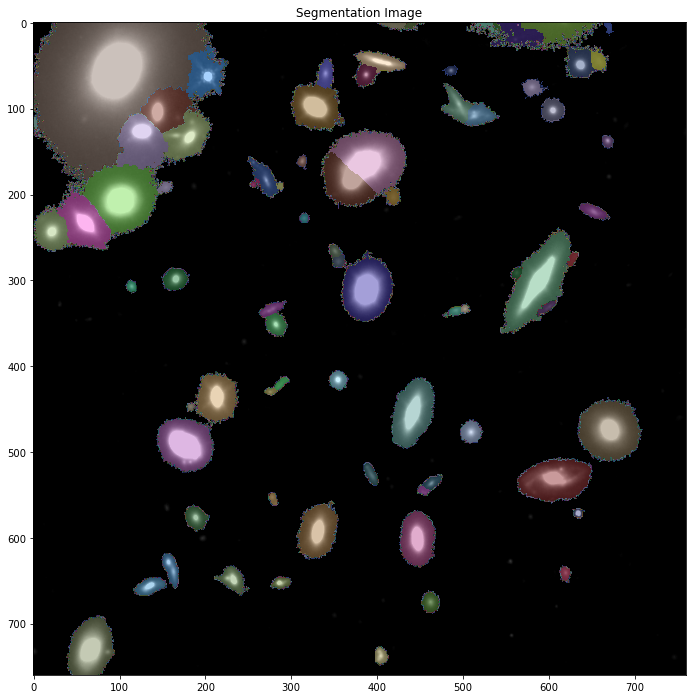

In [11]:
# Catalog
# -------

# Define detect threshold
#nsigma = image_8_sigma
#nsigma = image_3_sigma
#nsigma = image_mean
nsigma = 0 

# Define smoothing kernel

kernel_size=None

# Make segmentation map
segm = make_segments(image.data, nsigma=nsigma, kernel_size=kernel_size, fwhm=5, npixels=10**2)


# Deblend segmentation map
segm_deblend = deblend_segments(image.data, segm, contrast=0, kernel_size=kernel_size, fwhm=5, npixels=5**2)

# Remove border sources
#segm_deblend.remove_border_labels(1)

# Make catalog
cat = source_properties(image.data, segm_deblend, wcs=image.wcs)

# Display source properties
print("Num of Targets:", len(cat))

# Plot segments
plot_segments(segm_deblend, image.data, vmin=vmin, vmax=vmax)
plt.show()



In [12]:
# Test out masked_segm_image
def slider(x):
    plt.imshow(masked_segm_image(cat[x], image, segm_deblend).data, vmin=vmin, vmax=vmax)
    plt.show()

widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=76), Output()), _dom_classes=('widget-inter…

# Define Aperture Radii

In [17]:
# List of radii
# -------------
r_list = list(range(1, 201, 2))
#r_list += list(range(60, 201, 10))

#r_list = np.logspace(np.log10(0.06),np.log10(14), 10) * u.arcsec # approximate isophotal extent
#r_list = angular_to_pixel(r_list, wcs=image.wcs) # convert to pixels
#r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

r_list = np.array(r_list)
print("max=", r_list[-1])
print("len=", len(r_list))

max= 199
len= 100


# Photometry

In [21]:
def photometry_step(position, r_list, image, e=1., theta=0., annulus_dr=5,
                    subtract_bg=True, return_areas=False, bg_density=None,
                    plot=False, vmin=0, vmax=None):

    # Estimate background
    annulus = None
    if subtract_bg and bg_density is None:
        annulus = radial_elliptical_annulus(position, max(r_list), annulus_dr, e=e, theta=theta)
        bg_density = annulus.do_photometry(image.data)[0][0] / annulus.area

    aperture_photometry_row = []
    aperture_area_row = []

    if plot:
        plt.imshow(image.data, vmax=image.data.mean()*10 if vmax is None else vmax)
        
    for i, r in enumerate(r_list):

        aperture = radial_elliptical_aperture(position, r, e=e, theta=theta)
        aperture_area = aperture.area

        photometric_sum = aperture.do_photometry(image.data)[0][0]

        photometric_value = np.round(photometric_sum, 6)

        if np.isnan(photometric_value):
            raise Exception("Nan photometric_value")

        if subtract_bg:
            photometric_bkg =  np.round(aperture_area * bg_density, 6)
            photometric_value -= photometric_bkg
            
        if plot:
            aperture.plot(plt.gca(), color='w', alpha=0.5)

        aperture_photometry_row.append(photometric_value)
        aperture_area_row.append(aperture_area)

    if plot and annulus is not None:
        annulus.plot(plt.gca(), color='w', linestyle='--', alpha=0.5)

    if return_areas:
        return aperture_photometry_row, aperture_area_row
    else:
        return aperture_photometry_row

In [30]:
# Test photometry function
def slider(x):
    obj = cat[x]
    print(obj.id)
    
    fig, ax = plt.subplots(1, 2, figsize=[24,12])
    
    position = get_source_position(obj)
    masked_image = masked_segm_image(obj, image, segm_deblend, fill=0)
    masked_image = Cutout2D(masked_image.data, position, max(r_list)*3, mode='partial', fill_value=0)
    position = np.array(masked_image.data.shape) / 2.
    
    plt.sca(ax[0])
    aperture_photometry_row , a_list= photometry_step(position, r_list, masked_image, return_areas=True,
                                             plot=True, subtract_bg=True, bg_density=0, vmax=None)
    
    plt.sca(ax[1])
    plt.plot(r_list, aperture_photometry_row, c='black')
    for r in r_list:
        plt.axvline(r, alpha=0.5, c='r')
    plt.show()


widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=76), Output()), _dom_classes=('widget-inter…

In [16]:
# Photomerty
# ----------
pb = widgets.IntProgress(
    value=0,
    min=0,
    max=len(cat),
    step=1,
    description='Loading:',
    bar_style='',
    orientation='horizontal'
)
display(pb)

single_aperture_photometry_table = cat.to_table()

aperture_photometry_rows = []
aperture_area_rows = []
for idx, obj in enumerate(cat):
    pb.value = idx + 1
    pb.description = "{}/{}".format(pb.value, len(cat))
    
    #position = get_source_position(obj)
    #masked_image = masked_segm_image(obj, image, segm_deblend, fill=noise_mean)
    
    position = get_source_position(obj)
    masked_image = masked_segm_image(obj, image, segm_deblend, fill=0)
    masked_image = Cutout2D(masked_image.data, position, max(r_list)*3, mode='partial', fill_value=0)
    position = np.array(masked_image.data.shape) / 2.
    
    
    aperture_photometry_row, aperture_area_row = photometry_step(position, r_list, masked_image, 
                                                                 e=obj.elongation.value, 
                                                                 theta=np.deg2rad(obj.orientation.value),
                                                                 plot=False, subtract_bg=False, vmax=vmax/20, 
                                                                 return_areas=True, bg_density=False)
    
    aperture_photometry_rows.append(np.array(aperture_photometry_row))
    aperture_area_rows.append(aperture_area_row)
    
single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.add_columns(np.transpose(aperture_area_rows), names=["aperture_area_{:0>3}".format(r) for r in r_list])
single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
plt.show()

IntProgress(value=0, description='Loading:', max=77)

# Load Photometry Results

In [14]:
result_cat = Table.read(output_path)
result_cat.sort(keys="source_sum", reverse=1)
result_cat

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,aperture_sum_001,aperture_sum_145,aperture_sum_143,aperture_sum_141,aperture_sum_139,aperture_sum_137,aperture_sum_135,aperture_sum_133,aperture_sum_131,aperture_sum_129,aperture_sum_127,aperture_sum_125,aperture_sum_123,aperture_sum_121,aperture_sum_119,aperture_sum_117,aperture_sum_115,aperture_sum_113,aperture_sum_111,aperture_sum_109,aperture_sum_107,aperture_sum_105,aperture_sum_147,aperture_sum_103,aperture_sum_149,aperture_sum_153,aperture_sum_195,aperture_sum_193,aperture_sum_191,aperture_sum_189,aperture_sum_187,aperture_sum_185,aperture_sum_183,aperture_sum_181,aperture_sum_179,aperture_sum_177,aperture_sum_175,aperture_sum_173,aperture_sum_171,aperture_sum_169,aperture_sum_167,aperture_sum_165,aperture_sum_163,aperture_sum_161,aperture_sum_159,aperture_sum_157,aperture_sum_155,aperture_sum_151,aperture_sum_101,aperture_sum_099,aperture_sum_097,aperture_sum_043,aperture_sum_041,aperture_sum_039,aperture_sum_037,aperture_sum_035,aperture_sum_033,aperture_sum_031,aperture_sum_029,aperture_sum_027,aperture_sum_025,aperture_sum_023,aperture_sum_021,aperture_sum_019,aperture_sum_017,aperture_sum_015,aperture_sum_013,aperture_sum_011,aperture_sum_009,aperture_sum_007,aperture_sum_005,aperture_sum_003,aperture_sum_045,aperture_sum_047,aperture_sum_049,aperture_sum_051,aperture_sum_095,aperture_sum_093,aperture_sum_091,aperture_sum_089,aperture_sum_087,aperture_sum_085,aperture_sum_083,aperture_sum_081,aperture_sum_079,aperture_sum_077,aperture_sum_197,aperture_sum_075,aperture_sum_071,aperture_sum_069,aperture_sum_067,aperture_sum_065,aperture_sum_063,aperture_sum_061,aperture_sum_059,aperture_sum_057,aperture_sum_055,aperture_sum_053,aperture_sum_073,aperture_sum_199,aperture_area_001,aperture_area_145,aperture_area_143,aperture_area_141,aperture_area_139,aperture_area_137,aperture_area_135,aperture_area_133,aperture_area_131,aperture_area_129,aperture_area_127,aperture_area_125,aperture_area_123,aperture_area_121,aperture_area_119,aperture_area_117,aperture_area_115,aperture_area_113,aperture_area_111,aperture_area_109,aperture_area_107,aperture_area_105,aperture_area_147,aperture_area_103,aperture_area_149,aperture_area_153,aperture_area_195,aperture_area_193,aperture_area_191,aperture_area_189,aperture_area_187,aperture_area_185,aperture_area_183,aperture_area_181,aperture_area_179,aperture_area_177,aperture_area_175,aperture_area_173,aperture_area_171,aperture_area_169,aperture_area_167,aperture_area_165,aperture_area_163,aperture_area_161,aperture_area_159,aperture_area_157,aperture_area_155,aperture_area_151,aperture_area_101,aperture_area_099,aperture_area_097,aperture_area_043,aperture_area_041,aperture_area_039,aperture_area_037,aperture_area_035,aperture_area_033,aperture_area_031,aperture_area_029,aperture_area_027,aperture_area_025,aperture_area_023,aperture_area_021,aperture_area_019,aperture_area_017,aperture_area_015,aperture_area_013,aperture_area_011,aperture_area_009,aperture_area_007,aperture_area_005,aperture_area_003,aperture_area_045,aperture_area_047,aperture_area_049,aperture_area_051,aperture_area_095,aperture_area_093,aperture_area_091,aperture_area_089,aperture_area_087,aperture_area_085,aperture_area_083,aperture_area_081,aperture_area_079,aperture_area_077,aperture_area_197,aperture_area_075,aperture_area_071,aperture_area_069,aperture_area_067,aperture_area_065,aperture_area_063,aperture_area_061,aperture_area_059,aperture_area_057,aperture_area_055,aperture_area_053,aperture_area_073,aperture_area_199
int64,float64,float64,str38,str38,float64,str4,str4,str4,str4,float64,float64,floa

In [15]:
mag_col_names = natural_sort([i for i in result_cat.colnames if "aperture_sum_" in i])
area_col_names = natural_sort([i for i in result_cat.colnames if "aperture_area_" in i])

# Calculate Petrosian

In [18]:
def slider(x):
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    
    f, ax = plt.subplots(2, 2)

    ax[0,0].imshow(image.data, vmin=vmin, vmax=vmax)
    ax[0,0].set_xlim(x-size, x+size)
    ax[0,0].set_ylim(y-size, y+size)
    ax[0,0].set_title("Target {}".format(row['id']))
    
    ax[0,1].imshow(masked_image.data, vmin=vmin, vmax=vmax)
    ax[0,1].set_xlim(x-size, x+size)
    ax[0,1].set_ylim(y-size, y+size)
    ax[0,1].set_title("Target [Masked Image]")    
    
    position = [x, y]
    
    for r in r_list:
        aperture = radial_elliptical_aperture(position, r, e=obj_e, theta=obj_theta)
        aperture.plot(ax[0,0], color='r', alpha=0.5)
        aperture.plot(ax[0,1], color='r', alpha=0.5)


    # Plot Cumulative Photometry
    # --------------------------
    
    y_values = list(row[mag_col_names])
    ax[1,0].plot(r_list, y_values, label="Raw")
    
    ax[1,0].set_title("Cumulative Photometry")
    ax[1,0].set_xlabel("Aperture Radius [Pix]")
    ax[1,0].set_ylabel("Photometic Sum")
    
    ax[1,0].legend()
    
    # Plot Photometic Density
    # -----------------------
    
    y_values = calculate_photometic_density(r_list, flux_list, e=obj_e, theta=obj_theta)
    ax[1,1].plot(r_list, y_values, label="Raw") 
  
    ax[1,1].set_title("Photometic Density: sum(slice) / area(slice)")
    ax[1,1].set_xlabel("Aperture Radius [Pix]")
    ax[1,1].set_ylabel("Photometic Density")
    ax[1,1].axhline(0, c='black', label="Zero Level")
    ax[1,1].legend()
    
    plt.show()
    
    # Petrosian
    # ---------
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));

interactive(children=(BoundedIntText(value=0, description='x', max=76), Output()), _dom_classes=('widget-inter…

# Inspect r_half_light and r_total_flux

In [19]:
def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    plt.sca(ax[0])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    
    # Calculate petrosian
    # -------------------
    petrosian_number = 0.2
    r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=petrosian_number)
    if r_petrosian is None:
        print("r_petrosian could not be computed")
        return
    
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=petrosian_number)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=petrosian_number)
    
    
    # r_half_light and r_total_flux Plots
    # -----------------------------------
    size = int(r_total_flux * 1.5)
    position = [x, y]
    
    # r_total_flux 
    aperture = radial_elliptical_aperture(position, r_total_flux, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    # r_half_light
    if r_half_light is None:
        print("r_half_light could not be computed")
    else:
        aperture = radial_elliptical_aperture(position, r_half_light, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle="--", label='R Half Light')
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    
    plt.legend()
    
    plt.sca(ax[1])
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));


interactive(children=(BoundedIntText(value=0, description='x', max=76), Output()), _dom_classes=('widget-inter…

# Fit Sersic Model and Compare Cumulative Photometries

In [29]:
def slider(x):
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_ellip = row['ellipticity']
    obj_theta = np.deg2rad(row['orientation']) 
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend, fill=0)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    plt.figure(figsize=[2, 2])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    plt.show()
    
    # Calculate r_half_light
    # -------------------
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=0.2)
    if r_half_light is None:
        print('Could not calculate r_half_light')
        
        return 
    
    # Calculate flux(r_half_light)
    # ----------------------------
    ca = CircularAnnulus([x, y], r_half_light-1, r_half_light+1)
    flux_half_light = ca.do_photometry(masked_image.data)[0].sum() / ca.area
    
    # Make Cutout to fit
    # ------------------
    target_zoom = Cutout2D(masked_image.data, (x, y), max(r_list), mode='partial', fill_value=0)
    
    target_x, target_y = np.array(target_zoom.data.shape) / 2.
    
    # Make models to fit
    # ------------------
    xy_slack = 0
    model_1 = models.Sersic2D(
        amplitude=flux_half_light,
        n=1.5,
        r_eff=r_half_light,
        ellip=obj_ellip,
        theta=obj_theta,
        x_0=target_x,
        y_0=target_y,
        fixed={'x_0':True, 'y_0':True},# 'r_eff':True,},
        bounds={
            'amplitude': (0, None),
            'r_eff': (0, None),
            'n': (0, 7),
            'ellip': (0, 1),
            'theta': (0, 2 * np.pi),
            'x_0': (target_x - xy_slack, target_x + xy_slack),
            'y_0': (target_y - xy_slack, target_y + xy_slack),
        })
    
    model_2 = deepcopy(model_1)
    model_2.amplitude /= 4
    model_2.r_eff *= 2
    model_2.n = 1
    
    model_3 = models.Gaussian2D(
            amplitude=flux_half_light,
            x_mean=model_1.x_0,
            y_mean=model_1.y_0,
            x_stddev=model_1.r_eff,
            y_stddev=model_1.r_eff,
            fixed={'x_mean': True, 'y_mean': True, },
            bounds={
                'amplitude': (0, None),
            }
    )
    
    model = model_1 + model_2 + model_3
    model.x_0 = model_1.x_0
    model.y_0 = model_1.y_0
    
    # Fit model 
    # ---------
    model, fit = fit_model(target_zoom.data, model, maxiter=10000, epsilon=1e-40)
   
    
    # Compute flux in model
    model_image = model_to_image(max(r_list)+5, model)
        
    model_fluxs = photometry_step(np.array(model_image.shape)/2, r_list, model_image, 
                                 e=obj_e, theta=obj_theta,
                                 plot=False, subtract_bg=False, vmax=vmax/20, 
                                 return_areas=False)
    
    plt.plot(r_list, flux_list, label="Data", marker='o')
    plt.plot(r_list, model_fluxs, label="Model")
    
    plt.legend()
    plt.show()
    
    # Plot fit
    fig, ax = plot_fit(target_zoom.data, model, vmin=vmin, vmax=vmax)
    
    plt.show()
    #plt.imshow(model_image, vmin=vmin, vmax=vmax)
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));



interactive(children=(BoundedIntText(value=0, description='x', max=76), Output()), _dom_classes=('widget-inter…

# concentration_index

In [23]:
def calculate_concentration_index(r_list, area_list, flux_list, eta=0.2, ratio_1=0.2, ratio_2=0.8):
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=eta)

    if r_total_flux > max(r_list):
        return None

    r_list_new, flux_list_new = get_interpolated_values(r_list, flux_list)

    f = interp1d(r_list, flux_list, kind='cubic')
    total_flux = f(r_total_flux)
    
    flux_1 = total_flux * ratio_1
    flux_2 = total_flux * ratio_2

    idx1 = abs(flux_list_new - flux_1).argmin()
    idx2 = abs(flux_list_new - flux_2).argmin()
    
    if None in [idx1, idx2]:
        return None
    
    r1 = r_list_new[idx1]
    r2 = r_list_new[idx2]

    
    return r1, r2, 5 * np.log10(r1/r2)

In [28]:
row = result_cat[1]
area_list = np.array(list(row[area_col_names]))
flux_list = np.array(list(row[mag_col_names]))

obj_e = row['elongation']
obj_ellip = row['ellipticity']
obj_theta = np.deg2rad(row['orientation'])  

print("r_total=",calculate_r_total_flux(r_list, area_list, flux_list, eta=0.2))
calculate_concentration_index(r_list, area_list, flux_list, eta=0.2, ratio_1=0.2, ratio_2=0.8)

r_total= 44.22204440888178


(3.891378275655131, 16.01140228045609, -3.071629595533448)

In [27]:
def slider(x):
    
    row = result_cat[x]
    area_list = np.array(list(row[area_col_names]))
    flux_list = np.array(list(row[mag_col_names]))
    
    obj_e = row['elongation']
    obj_theta = np.deg2rad(row['orientation'])
    
    masked_image = masked_segm_image(row['id'], image, segm_deblend)
    
    size = max(r_list)
    x, y = get_source_position(row)
    
    # Plot Target
    # -----------
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    plt.sca(ax[0])
    plot_target((x, y), image, size, vmin=vmin, vmax=vmax)
    plt.title("Target {}".format(row['id']))
    
    # Calculate petrosian
    # -------------------
    petrosian_number = 0.2
    r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=petrosian_number)
    if r_petrosian is None:
        print("r_petrosian could not be computed")
        return
    
    r_total_flux = calculate_r_total_flux(r_list, area_list, flux_list, eta=petrosian_number)
    r_half_light = calculate_r_half_light(r_list, area_list, flux_list, eta=petrosian_number)
    r1, r2, c2080 = calculate_concentration_index(r_list, area_list, flux_list, eta=obj_e, ratio_1=0.2, ratio_2=0.8)
    
    # r_half_light and r_total_flux Plots
    # -----------------------------------
    size = int(r_total_flux * 1.5)
    position = [x, y]
    
    # r_total_flux 
    aperture = radial_elliptical_aperture(position, r_total_flux, e=obj_e, theta=obj_theta)
    aperture.plot(plt.gca(), color='r', label='R Total')
    
    # r_half_light
    if None in [r_half_light, r1, r2]:
        print("Could not be computed")
    else:
        aperture = radial_elliptical_aperture(position, r_half_light, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle="-", label='R Half Light')
        aperture = radial_elliptical_aperture(position, r1, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle=':', label='R_20')
        aperture = radial_elliptical_aperture(position, r2, e=obj_e, theta=obj_theta)
        aperture.plot(plt.gca(), color='r', linestyle=':', label='R_80')
    
    plt.xlim(x-size, x+size)
    plt.ylim(y-size, y+size)
    
    plt.legend()
    
    plt.sca(ax[1])
    plot_petrosian(r_list, area_list, flux_list)
    plt.show()
    
widgets.interact(slider, x=widgets.BoundedIntText(min=0, max=len(result_cat)-1));



interactive(children=(BoundedIntText(value=0, description='x', max=76), Output()), _dom_classes=('widget-inter…

# Old Code

In [ ]:
# Old code
"""
for current_filter in  filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 1000)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    #nsigma = np.zeros_like(image) + image.mean() / 3
    nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    #plot_segments(segm_deblend, image)
    
    segm_deblend.remove_border_labels(50)

    cat = source_properties(image, segm_deblend, wcs=image_wcs)
    
    # Photomerty
    # ----------
    plot = False
    r_list = list(range(1, 41, 1))
    #r_list = np.logspace(np.log10(0.06),np.log10(14), 50) * u.arcsec # approximate isophotal extent
    #r_list = angular_to_pixel(r_list, wcs=wcs) # convert to pixels
    #r_list = np.unique(np.round(r_list).astype(int)) # convert to int 

    single_aperture_photometry_table = cat.to_table()

    aperture_photometry_rows = []

    pb = widgets.IntProgress(
        value=0,
        min=0,
        max=len(cat),
        step=1,
        description='Loading:',
        bar_style='',
        orientation='horizontal'
    )

    display(pb)

    for idx, obj in enumerate(cat):
        pb.value = idx + 1
        pb.description = "{}/{}".format(pb.value, len(cat))
        
        cut = obj.segment.make_cutout(image, masked_array=True)
        cy, cx = np.unravel_index(cut.argmax(), cut.shape)

        x = obj.segment.bbox.ixmin + cx
        y = obj.segment.bbox.iymin + cy

        #x = obj.xcentroid.value
        #y = obj.ycentroid.value
        single_aperture_photometry_table[idx]['xcentroid'] = x * u.pix
        single_aperture_photometry_table[idx]['ycentroid'] = y * u.pix

        position = np.transpose((x, y))
        
        mask = ((segm_deblend.data == 0 ) | (segm_deblend.data == obj.id))
        masked_image = image.copy()
        masked_image[np.invert(mask)] = np.nan

        annulus = CircularAnnulus(position, r_list[-1], r_list[-1]*2)

        annulus_mask = annulus.to_mask(method='center')
        annulus_data = annulus_mask.multiply(masked_image)
        annulus_data_1d = annulus_data[(annulus_mask.data > 0) & (np.invert(np.isnan(annulus_data)))]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        
        masked_image[np.invert(mask)] =  median_sigclip

        aperture_photometry_row = []

        if plot:
            f, ax = plt.subplots(1, 1)
        for i, r in enumerate(r_list):

            aperture = CircularAperture(position, r)

            photometric_sum = aperture.do_photometry(masked_image, mask=None)[0][0] 
            
            #photometric_bkg = aperture.area * (annulus.do_photometry(masked_image)[0][0] / annulus.area)
            photometric_bkg = median_sigclip * aperture.area

            photometric_value = photometric_sum - photometric_bkg

            if plot:
                ax.imshow(masked_image, vmin=0, vmax=image.mean())
                aperture.plot(ax, color='r')

            aperture_photometry_row.append(photometric_value)
        if plot:
            plt.show()

        aperture_photometry_rows.append(np.array(aperture_photometry_row))

    single_aperture_photometry_table.add_columns(np.transpose(aperture_photometry_rows), names=["aperture_sum_{:0>3}".format(r) for r in r_list])

    single_aperture_photometry_table.sort(keys="source_sum", reverse=1)
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    plt.show()
    break
print("done")
"""; 

In [ ]:
"""
def compute_petrosian_r(area_list, flux_list, eta=0.2, e=1.):
    
    petrosian_list = calculate_petrosian(area_list, flux_list)
    f = interp1d(area_list, petrosian_list, kind='cubic')

    area_list_new = np.linspace(min(area_list), max(area_list), num=1000, endpoint=True)

    cutoff_idx = np.where((area_list_new <= max(area_list)) & (area_list_new >= min(area_list)))[0]
    area_list_new = area_list_new[cutoff_idx]

    petrosian_list_new = f(area_list_new)
    
    idx_list = np.where(petrosian_list_new <= eta)[0]
    
    r_petrosian = None
    if idx_list.size > 0:
        idx =  idx_list[0] 
        r_petrosian = elliptical_area_to_r(area_list_new[idx], e=e)[0]
        
    return r_petrosian
"""

In [ ]:
"""
max_a = max(r_list)
max_b = max_a / obj_e

annulus_inner = 1 # inner ring multiplier
annulus_outter = (max_a+2)/max_a # outter ring multiplier

annulus = EllipticalAnnulus(position, 
                            max_a*annulus_inner, 
                            max_a*annulus_outter, 
                            max_b*annulus_outter, 
                            theta=obj_theta) 

annulus.plot(ax[0,0], color='w')
annulus.plot(ax[0,1], color='w')
"""

In [ ]:
"""
row = result_cat[17]
obj = cat[row['id']-1]
assert obj.id == row['id']
masked_image = masked_segm_image(obj, image, segm_deblend)

obj_e = obj.elongation.value
obj_theta = obj.orientation.to(u.rad).value

petrosian_number = 0.2
    
area_list = np.array(list(row[area_col_names]))
flux_list = np.array(list(row[mag_col_names]))
petrosian_list = calculate_petrosian(area_list, flux_list)

r_list_new, petrosian_list_new = get_interpolated_values(r_list, petrosian_list)

plt.plot(r_list, petrosian_list, 'o', r_list_new, petrosian_list_new, '-')

r_petrosian = calculate_petrosian_r(r_list, area_list, flux_list, eta=0.2)
if r_petrosian is not None:
    idx = closest_value_index(petrosian_number, petrosian_list_new)
    plt.axvline(r_petrosian, linestyle='--')
    plt.axhline(petrosian_list_new[idx], linestyle='--')
print(r_petrosian)
"""

In [ ]:
"""
def calculate_circle_petrosian(flux_list, r_list):
    
    petrosian_list = []
    
    last_r = 0
    last_I = 0
    for i in range(len(r_list)):
        r = r_list[i]
        I = flux_list[i]
        
        area_of_slice = (np.pi * (r**2 - last_r**2))
        I_at_r = (I - last_I) / area_of_slice 
        
        area_within_r = (np.pi * r**2)
        I_avg_within_r = (I / area_within_r)

        petrosian_value = I_at_r / I_avg_within_r
        
        petrosian_list.append(petrosian_value)
        
        last_r = r
        last_I = I 
        
    return petrosian_list
"""

In [ ]:
"""
def photometry_step(obj, r_list, image, segm_deblend, plot=False, subtract_bg=True, return_areas=False):
    """
    # Inputs if using cell mode (commenting out the function def and unindent)
    obj = cat[0]
    plot = True
    subtract_bg = True 
    """

    # Load full image mask
    mask = segm_mask(obj, segm_deblend)

    # Center of object
    # x, y = obj.xcentroid.value, obj.ycentroid.value
    x, y = obj.maxval_xpos.value, obj.maxval_ypos.value

    position = np.transpose((x, y))

    obj_e = obj.elongation.value
    obj_theta = obj.orientation.to(u.rad).value

    # Estimate background
    bg_density = None 
    if subtract_bg:
        max_a = max(r_list)
        max_b = max_a / obj_e

        annulus_inner = 1 # inner ring multiplier
        annulus_outter = (max_a+2)/max_a # outter ring multiplier

        annulus = EllipticalAnnulus(position, 
                                    max_a*annulus_inner, 
                                    max_a*annulus_outter, 
                                    max_b*annulus_outter, 
                                    theta=obj_theta) 
        
        annulus_mask = annulus.to_mask().multiply(mask)
        annulus_area = annulus_mask.sum()
        bg_density = (annulus.do_photometry(image.data, mask=np.invert(mask))[0][0] / annulus_area)

    masked_image = masked_segm_image(obj, image, segm_deblend, fill=noise_mean)

    aperture_photometry_row = []
    aperture_area_row = []

    if plot:
        f, ax = plt.subplots(1, 1)
        ax.imshow(masked_image.data, vmax=image.data.mean())
    for i, r in enumerate(r_list):
        
        aperture = radial_elliptical_aperture(position, r, obj_e, obj_theta)
        aperture_area = aperture.area#(aperture.to_mask().multiply(masked_image.data > 0)).sum()


        masked_image = masked_segm_image(obj, image, segm_deblend, fill=0)
        photometric_sum = aperture.do_photometry(masked_image.data)[0][0]

        photometric_value = photometric_sum 

        if subtract_bg:
            photometric_bkg = aperture_area * noise_mean
            photometric_value -= photometric_bkg
        if np.isnan(photometric_value):
            raise Exception("Nan photometric_value")
        if plot:
            aperture.plot(ax, color='r')
            
        aperture_photometry_row.append(photometric_value)
        aperture_area_row.append(aperture_area)

    if plot:
        if subtract_bg:
            annulus.plot(ax, color='w', linestyle='--')
        plt.show()
        
    if return_areas:
        return aperture_photometry_row, aperture_area_row
    else:
        return aperture_photometry_row
"""



In [ ]:
"""
  model_fluxs_2 = []
    for r in r_list:
        aperture = radial_elliptical_aperture(np.array(model_image.shape)/2, r, obj_e, obj_theta)
        model_flux = aperture.do_photometry(model_image)[0][0]
        model_fluxs_2.append(model_flux)
"""